# Original Copyright notice
Copyright (c) 2018, Miguel Morales
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Original URL
[Chapter 5 notebook](https://github.com/mimoralea/gdrl/blob/master/notebooks/chapter_05/chapter-05.ipynb)

In [3]:
# on-policy first-visit MC prediction, on-policy every-visit MC prediction, TD, n-step TD, TD(λ)

In [4]:
# Hack to load the gym_walk and gym_aima modules
import sys
import os
   
sys.path.append(os.path.abspath('../../../'))

In [5]:
import warnings ; warnings.filterwarnings('ignore')

import gymnasium as gym
import src.gym_walk, src.gym_aima
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle, count

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [6]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [7]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    """
    Policy evaluation using the Bellman equation.
    
    Args:
        pi: Policy function.
        P: Transition probability matrix.
        gamma: Discount factor.
        theta: Convergence threshold.
        
    """
    prev_V = np.zeros(len(P), dtype=np.float64)
    while True:
        V = np.zeros(len(P), dtype=np.float64)
        for s in range(len(P)):
            for prob, next_state, reward, done in P[s][pi(s)]:
                V[s] += prob * (reward + gamma * prev_V[next_state] * (not done))
        if np.max(np.abs(prev_V - V)) < theta:
            break
        prev_V = V.copy()
    return V

In [8]:
def print_policy(pi, P, action_symbols=('<', 'v', '>', '^'), n_cols=4, title='Policy:'):
    print(title)
    arrs = {k:v for k,v in enumerate(action_symbols)}
    for s in range(len(P)):
        a = pi(s)
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), arrs[a].rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [9]:
def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

In [10]:
def print_action_value_function(Q, 
                                optimal_Q=None, 
                                action_symbols=('<', '>'), 
                                prec=3, 
                                title='Action-value function:'):
    vf_types=('',) if optimal_Q is None else ('', '*', 'er')
    headers = ['s',] + [' '.join(i) for i in list(itertools.product(vf_types, action_symbols))]
    print(title)
    states = np.arange(len(Q))[..., np.newaxis]
    arr = np.hstack((states, np.round(Q, prec)))
    if not (optimal_Q is None):
        arr = np.hstack((arr, np.round(optimal_Q, prec), np.round(optimal_Q-Q, prec)))
    print(tabulate(arr, headers, tablefmt="fancy_grid"))

In [11]:
def probability_success(env, pi, goal_state, n_episodes=100, max_steps=200):
    random.seed(123)
    np.random.seed(123)
    env.action_space.seed(123)
    results = []
    for _ in range(n_episodes):
        state,info=env.reset()
        done, steps =  False, 0
        while not done and steps < max_steps:
            state, reward, done, _, _ = env.step(pi(state))
            steps += 1
        results.append(state == goal_state)
    return np.sum(results)/len(results)*100

In [12]:
def mean_return(env, gamma, pi, n_episodes=100, max_steps=200):
    random.seed(123)
    np.random.seed(123) 
    env.action_space.seed(123)
    results = []
    for _ in range(n_episodes):
        state, info=env.reset()
        done, steps =  False, 0
        results.append(0.0)
        while not done and steps < max_steps:
            state, reward, done, _, _ = env.step(pi(state))
            results[-1] += (gamma**steps * reward)
            steps += 1
    return np.mean(results)

In [13]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y)**2)), dp)

In [14]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=5):
    plt.figure(figsize=(6, 4))
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-", "--", ":", "-."])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values, 
                                  min(len(valid_values), limit_items), 
                                  replace=False)
    # Draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = 'v({})'.format(i)
            plt.axhline(y=V_true[i], color='k', linestyle='-', linewidth=0.5)
            plt.text(int(len(V_track) * 1.02), V_true[i] + 0.01, label, fontsize=8)  # Smaller font for text

    # Then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, line_type, label=label, linewidth=1)  # Reduced line width for better scaling
        legends.append(p)
        
    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx + per_col]
        l = plt.legend(subset, [p.get_label() for p in subset], 
                       loc='center right', bbox_to_anchor=(1.25, 0.5), fontsize=8)  # Smaller font for legend
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    
    if log:
        plt.xscale('log')
    plt.title(title, fontsize=10)  # Smaller font for title
    plt.ylabel('State-value function', fontsize=8)  # Smaller font for y-axis label
    plt.xlabel('Episodes (log scale)' if log else 'Episodes', fontsize=8)  # Smaller font for x-axis label
    plt.xticks(fontsize=6)  # Smaller font for x-ticks
    plt.yticks(fontsize=6)  # Smaller font for y-ticks
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [15]:
def plot_targets(targets, init_state, title):
    plt.figure(figsize=(6, 4))
    x = range(len(targets[init_state]))
    y = targets[init_state]
    
    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=0.5)
    plt.text(int(x[-1]*1.02), V_true[init_state] + 0.01, label, fontsize=8)  # Smaller font for text

    plt.scatter(x, y, 
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4,s=10)
    plt.title(title, fontsize=10)  # Smaller font for title
    plt.ylabel('Target value', fontsize=8)  # Smaller font for y-axis label
    plt.xlabel('Estimate sequence number', fontsize=8)  # Smaller font for x-axis label
    plt.xticks(fontsize=6)  # Smaller font for x-ticks
    plt.yticks(fontsize=6)  # Smaller font for y-ticks
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [16]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

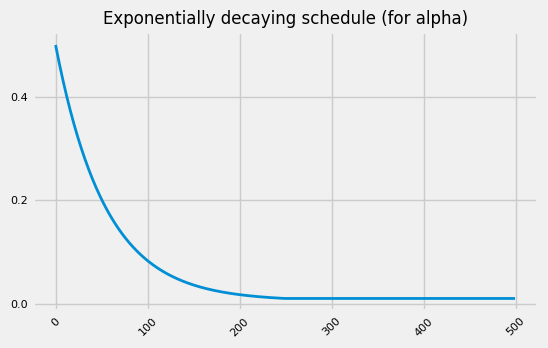

In [17]:
plt.figure(figsize=(6, 4))  # Small figure size
plt.plot(decay_schedule(0.5, 0.01, 0.5, 500),linewidth=2)
plt.title('Exponentially decaying schedule (for alpha)', fontsize=12)  # Smaller title font
plt.xticks(fontsize=8, rotation=45)  # Smaller x-tick font and rotated
plt.yticks(fontsize=8)  # Smaller y-tick font
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Random walk/Deterministic walk with uniformly random policy

In [18]:

env = gym.make('RandomWalk-v0')
init_state, info = env.reset()
goal_state = 6
gamma = 1.0
n_episodes = 500
P = env.unwrapped.P

LEFT, RIGHT = range(2)
pi = lambda s: {
    0:LEFT, 1:LEFT, 2:LEFT, 3:LEFT, 4:LEFT, 5:LEFT, 6:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P, n_cols=7)
print()
print_policy(pi, P, action_symbols=('<', '>'), n_cols=7)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.083 | 01  0.167 | 02  0.333 | 03    0.5 | 04  0.667 | 05  0.833 | 06  0.417 |

Policy:
| 00      < | 01      < | 02      < | 03      < | 04      < | 05      < | 06      < |
Reaches goal 56.00%. Obtains an average return of 0.5100.


# First-visit Monte-Carlo prediction
The first-visit Monte-Carlo approch only counts the first time we see a state in the trajectory.


## First-Visit Monte Carlo Prediction Algorithm from lectures notes
The following pseudo-code is based on [Emma Brunskill lectures notes](https://web.stanford.edu/class/cs234/modules.html) from Lecture 3.

First a bit of terminology:
* $N(s)$ is the count of first visits to state $s$.
* $G_{sum}(s)$ is the sum of returns for state $s$ following first visits.
* $V_\pi(s)$ is the value function for policy $\pi$ that we are approximating.
* $T_i$ is the terminal time step of episode $i$.
* $r_{i,t}$ is taken as the reward available at step $t$ onwards.
* $G_{i,t}$ is the return from this time step $t$ onwards for episode $i$:
                $$G_{i,t} = r_{i,t} + \gamma r_{i,t+1} + \gamma^2 r_{i,t+2} + \dots + \gamma^{T_i-t} r_{i,T_i} = \sum_{k=0}^{T_i-t} \gamma^k r_{i,t+k}$$
                
1.  **Initialization:**
    * Initialize $N(s) = 0$ for all states $s \in S$. .
    * Initialize $G_{sum}(s) = 0$ for all states $s \in S$.
    * Initialize $V_\pi(s)$ arbitrarily (e.g., $V_\pi(s) = 0$) for all states $s \in S$, or it will be derived from $G_{sum}(s)/N(s)$.

2.  **Loop (for each episode):**
    * Sample episode $i$ using policy $\pi$. The episode is a sequence of state, action, reward tuples:
        $e_i = (s_{i,1}, a_{i,1}, r_{i,1}), (s_{i,2}, a_{i,2}, r_{i,2}), \dots, (s_{i,T_i}, a_{i,T_i}, r_{i,T_i})$

    * For each time step $t = 1, 2, \dots, T_i$ in episode $i$:
        * Let $s = s_{i,t}$ be the state visited at time step $t$.
        * **First-Visit Check:** If this occurrence of state $s$ at time step $t$ is the *first time* state $s$ has been visited in *this current episode $i$*:
            
            1.  **Increment Counter:** Update the total count of first visits for state $s$:
                $$N(s) = N(s) + 1$$

            2.  **Increment Total Return:** Add the new return to the sum of returns for state $s$:
                $$G_{sum}(s) = G_{sum}(s) + G_{i,t}$$
                (Using $G_{sum}(s)$ to match your "total return $G(s)$" to avoid confusion with $G_{i,t}$)

            3.  **Update Estimate:** Update the value estimate for state $s$:
                $$V_\pi(s) = \frac{G_{sum}(s)}{N(s)}$$



In [19]:
def generate_trajectory(pi, env, max_steps=200):
    """
    For a given policy pi, runs a single episode and returns the trajectory.
    
    This function generates trajectories for complete episodes, if max_steps
    is reached, the episode is reset and the trajectory is returned. 
    This is not very data efficient, but it is simple to implement and understand.

    Args:
        pi: Policy function.
        env: Gymnasium environment.
        max_steps: Maximum number of steps per episode.
        
    Returns:
        trajectory: List of tuples containing the state, action, reward, next state, and done flag for each step in the episode.
    
    """
    done, trajectory = False, []
    # Run until it is done 
    while not done:
        state, info = env.reset()
        for t in count():
            action = pi(state) 
            next_state, reward, done, _,_ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            # If max_steps is reached, reset the trajectory and start again
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

## First visit Monte Carlo algorightm implementation description
Here we try to use the notation of the previous section to describe the implementation below

                
1.  **Initialization:**
    * Initialize $N(s) = 0$ for all states $s \in S$. .
    * Initialize $G_{sum}(s) = 0$ for all states $s \in S$.
    * Initialize $V_\pi(s)$ arbitrarily (e.g., $V_\pi(s) = 0$) for all states $s \in S$, or it will be derived from $G_{sum}(s)/N(s)$.
    * Calculate the learning rate schedule array:
    `discounts` $\leftarrow \mathbf{\alpha} = [\alpha_0, \alpha_1, \dots, \alpha_{n_e}]$ where $n_e$ is the number of episodes. 
    
    * Precompute discount factors: `discount_factors` $\leftarrow [\gamma^0, \gamma^1, \dots, \gamma^{T-1}]$.

2.  **Loop (for each episode):**
    * Sample episode $i$ using policy $\pi$. The episode is a sequence of state, action, reward tuples:
        $e_i = (s_{i,1}, a_{i,1}, r_{i,1}), (s_{i,2}, a_{i,2}, r_{i,2}), \dots, (s_{i,T_i}, a_{i,T_i}, r_{i,T_i})$

    * For each time step $t = 1, 2, \dots, T_i$ in episode $i$:
        * Let $s = s_{i,t}$ be the state visited at time step $t$.
        * **First-Visit Check:** If this occurrence of state $s$ at time step $t$ is the *first time* state $s$ has been visited in *this current episode $i$*:
            
            1.  **Increment Counter:** Update the total count of first visits for state $s$:
                $$N(s) = N(s) + 1$$

            2.  **Compute $G_{i,t}$:** Compute the discounted return from the current time step $t$ in episode $i$ until the end of the episode ($T_i$). This can be expressed as the scalar product of a discount factor vector and a reward vector.

                Let $\mathbf{d}_{t \rightarrow T_i}$ be the column vector of discount factors applicable from step $t$:
                $$\mathbf{d}_{t \rightarrow T_i} = \begin{pmatrix} \gamma^0 \\ \gamma^1 \\ \gamma^2 \\ \vdots \\ \gamma^{T_i-t} \end{pmatrix}$$
                And let $\mathbf{r}_{i, t \rightarrow T_i}$ be the column vector of rewards from step $t$ to $T_i$ in episode $i$:
                $$\mathbf{r}_{i, t \rightarrow T_i} = \begin{pmatrix} r_{i,t} \\ r_{i,t+1} \\ r_{i,t+2} \\ \vdots \\ r_{i,T_i} \end{pmatrix}$$
                The return $G_{i,t}$ is then computed as:
                $$G_{i,t} = (\mathbf{d}_{t \rightarrow T_i})^T \mathbf{r}_{i, t \rightarrow T_i} = [\gamma^0, \gamma^1, \gamma^2, \dots, \gamma^{T_i-t}] \begin{pmatrix} r_{i,t} \\ r_{i,t+1} \\ r_{i,t+2} \\ \vdots \\ r_{i,T_i} \end{pmatrix}$$
                This is equivalent to the sum:
                $$G_{i,t} = \sum_{k=0}^{T_i-t} \gamma^k r_{i,t+k}$$

            3.  **Update Estimate:** Update the value estimate for state $s$ using the :
                $$V_{\pi}^{new} (s)= V_{\pi}^{old}(s)+\alpha_t\left[ G_{i,t}(s) - V_{\pi}^{old}(s)\right]$$

In [20]:
from dataclasses import dataclass

@dataclass
class PredictionConfig:
    """
    Configuration for the prediction algorithm.

    Attributes:
        gamma: Discount factor.
        init_alpha: Initial learning rate.
        min_alpha: Minimum learning rate.
        alpha_decay_ratio: Ratio of learning rate decay.
        n_episodes: Number of episodes to run.
        max_steps: Maximum number of steps per episode.
    """
    gamma: float = 1.0
    init_alpha: float = 0.5
    min_alpha: float = 0.01
    alpha_decay_ratio: float = 0.5
    n_episodes: int = 500
    max_steps: int = 200
    

def mc_prediction(pi, 
                  env, 
                  config: PredictionConfig,
                  first_visit: bool = True,):
    
    nS = env.observation_space.n
    discounts = np.logspace(0, 
                            config.max_steps, 
                            num=config.max_steps, 
                            base=config.gamma, 
                            endpoint=False)
    alphas = decay_schedule(config.init_alpha, 
                            config.min_alpha, 
                            config.alpha_decay_ratio, 
                            config.n_episodes)
    # Value function for each state given the policy pi
    V = np.zeros(nS, dtype=np.float64)
    # Track the value function for each episode
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(pi, 
                                         env, 
                                         config.max_steps)
        # Track the first visit of each state in the current episode
        visited = np.zeros(nS, dtype=np.bool)
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if visited[state] and first_visit:
                continue
            visited[state] = True

            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            targets[state].append(G)
            mc_error = G - V[state]
            V[state] = V[state] + alphas[e] * mc_error
        V_track[e] = V
    return V.copy(), V_track, targets

## FVMC Data generation

In [21]:
# Run a first-visit Monte-Carlo simulation for a few seeds 
# and keep track of the value function and the per episode 
# value function estimates

# Value function estimates
V_fvmcs=[]
# Per episode value function estimates
V_track_fvmcs = []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed) 
    env.action_space.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_fvmcs.append(V_fvmc) 
    V_track_fvmcs.append(V_track_fvmc)
# Average over all seeds
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs
del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## FVMC comparison with true value fuction `V_true`$=v_\pi^*(s)$

In [22]:
print_state_value_function(V_fvmc, P, n_cols=7)
print()
print_state_value_function(V_fvmc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
| 00    0.0 | 01  0.154 | 02  0.333 | 03  0.514 | 04  0.682 | 05  0.841 | 06    0.0 |

State-value function errors:
| 00 -0.083 | 01 -0.013 | 02    0.0 | 03  0.014 | 04  0.015 | 05  0.008 | 06 -0.417 |
RMSE: 0.1609


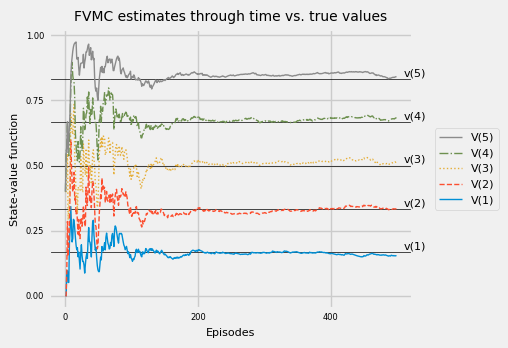

In [23]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

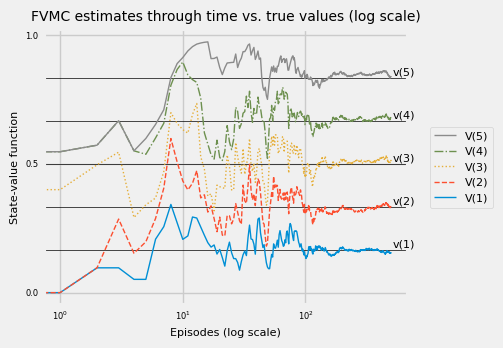

In [24]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

# Every-visit Monte-Carlo prediction

In [25]:
# Run a every-visit Monte-Carlo simulation for a few seeds 
# and keep track of the value function and the per episode 
# value function estimates

V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed) 
    env.action_space.seed(seed)
    
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes), first_visit=False)
    V_evmcs.append(V_evmc) 
    V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs
del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

## EVMC comparison with true value fuction `V_true`$=v_\pi^*(s)$

In [26]:
print_state_value_function(V_evmc, P, n_cols=7)
print()
print_state_value_function(V_evmc - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
| 00    0.0 | 01  0.154 | 02  0.302 | 03  0.469 | 04  0.624 | 05  0.798 | 06    0.0 |

State-value function errors:
| 00 -0.083 | 01 -0.013 | 02 -0.032 | 03 -0.031 | 04 -0.042 | 05 -0.035 | 06 -0.417 |
RMSE: 0.1629


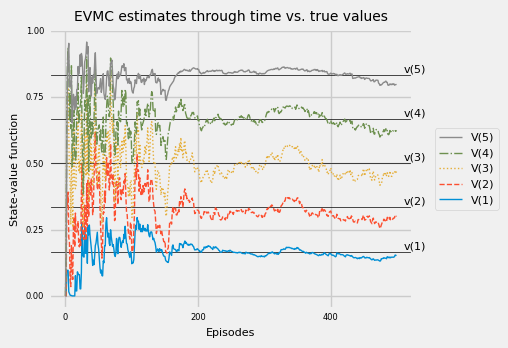

In [27]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

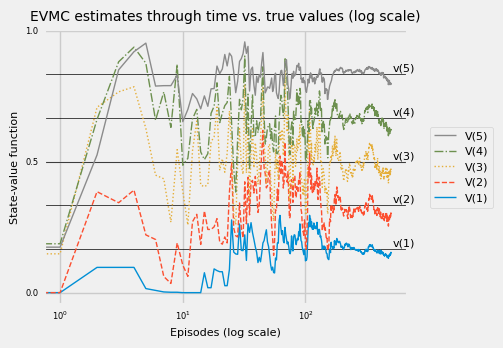

In [28]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

# Temporal-Difference Prediction (TD)

In [29]:
def td(pi, 
       env, 
       config: PredictionConfig):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    targets = {state:[] for state in range(nS)}
    alphas = decay_schedule(
        config.init_alpha, config.min_alpha,
        config.alpha_decay_ratio, config.n_episodes)
    for e in tqdm(range(config.n_episodes), leave=False):
        state, info = env.reset()
        done = False
        while not done:
            action = pi(state)

            next_state, reward, done, _,_ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            targets[state].append(td_target)
            td_error = td_target - V[state]
            V[state] = V[state] + alphas[e] * td_error
            state = next_state
        V_track[e] = V
    return V, V_track, targets

In [30]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [31]:
print_state_value_function(V_td, P, n_cols=7)
print()
print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00    0.0 | 01   0.17 | 02  0.349 | 03  0.521 | 04  0.688 | 05  0.845 | 06    0.0 |

State-value function errors:
| 00 -0.083 | 01  0.003 | 02  0.015 | 03  0.021 | 04  0.021 | 05  0.011 | 06 -0.417 |
RMSE: 0.1612


## TD learning comparison with true value fuction `V_true`$=v_\pi^*(s)$

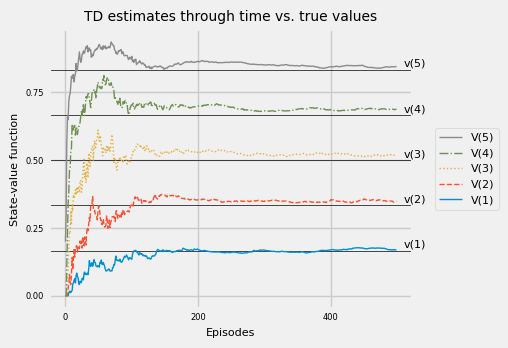

In [32]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

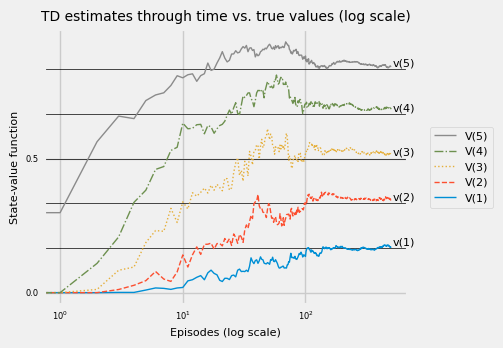

In [33]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

# Comparing MC and TD

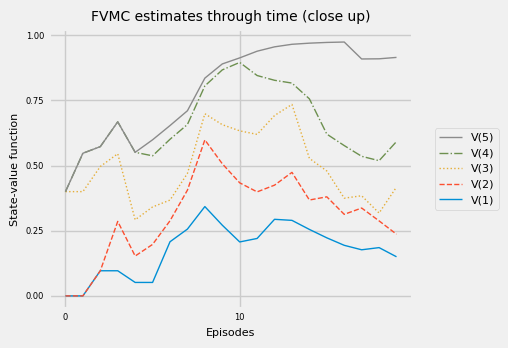

In [34]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:20], None, log=False)

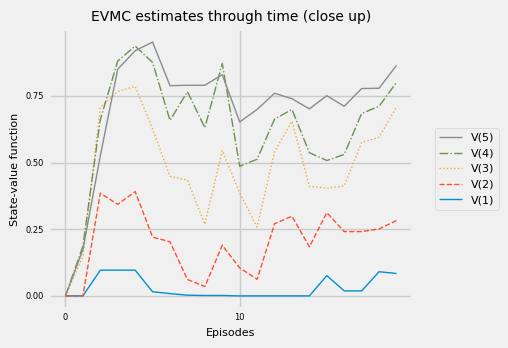

In [35]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:20], None, log=False)

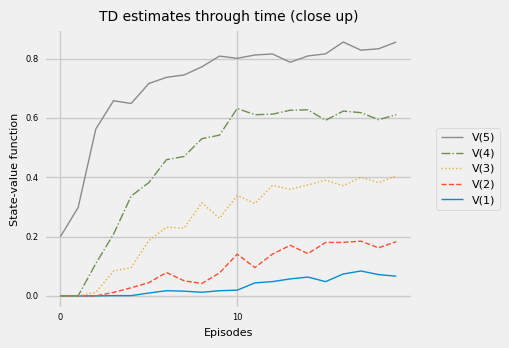

In [36]:
plot_value_function('TD estimates through time (close up)', V_track_td[:20], None, log=False)

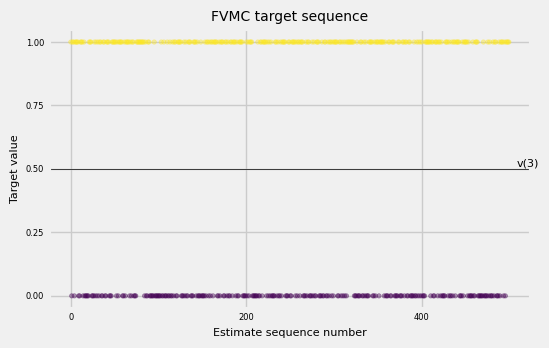

In [37]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

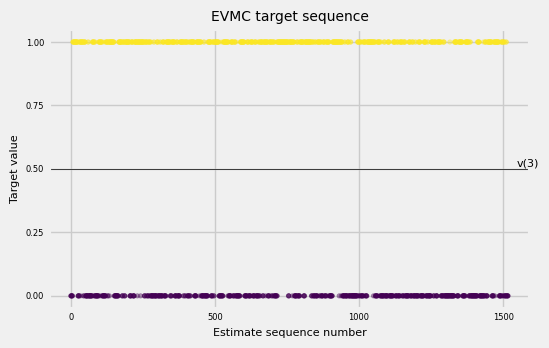

In [38]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

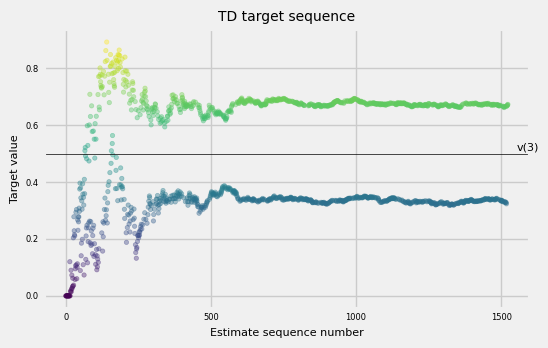

In [39]:
plot_targets(targets_td, init_state, title='TD target sequence')

# n-step TD

In [40]:
def ntd(pi, 
        env, 
        config: PredictionConfig,
        n_step=3):
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    discounts = np.logspace(0, n_step+1, num=n_step+1, base=gamma, endpoint=False)
    alphas = decay_schedule(
        config.init_alpha, config.min_alpha, 
        config.alpha_decay_ratio, config.n_episodes)
    for e in tqdm(range(config.n_episodes), leave=False):
        state, info = env.reset()
        done =False
        path = []
        while not done or path is not None:
            path = path[1:]
            while not done and len(path) < n_step:
                action = pi(state)
                next_state, reward, done, _,_ = env.step(action)
                experience = (state, reward, next_state, done)
                path.append(experience)
                state = next_state
                if done:
                    break

            n = len(path)
            est_state = path[0][0]
            rewards = np.array(path)[:,1]
            partial_return = discounts[:n] * rewards
            bs_val = discounts[-1] * V[next_state] * (not done)
            ntd_target = np.sum(np.append(partial_return, bs_val))
            ntd_error = ntd_target - V[est_state]
            V[est_state] = V[est_state] + alphas[e] * ntd_error
            if len(path) == 1 and path[0][3]:
                path = None

        V_track[e] = V
    return V, V_track

In [41]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed) 
    env.action_space.seed(seed)

    V_ntd, V_track_ntd = ntd(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_ntds.append(V_ntd)
    V_track_ntds.append(V_track_ntd)
    
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds 
del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [42]:
print_state_value_function(V_ntd, P, n_cols=7)
print()
print_state_value_function(V_ntd - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00    0.0 | 01  0.166 | 02   0.32 | 03  0.498 | 04  0.663 | 05  0.823 | 06    0.0 |

State-value function errors:
| 00 -0.083 | 01   -0.0 | 02 -0.013 | 03 -0.002 | 04 -0.003 | 05  -0.01 | 06 -0.417 |
RMSE: 0.1607


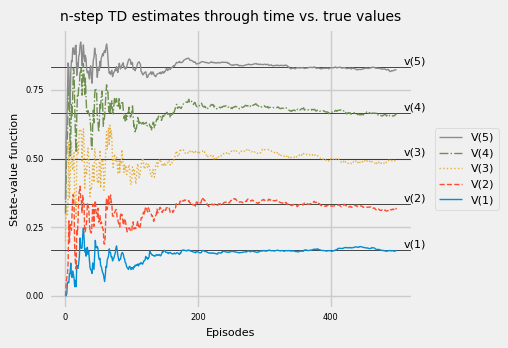

In [43]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

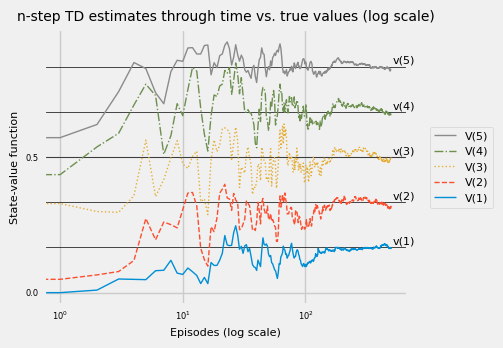

In [44]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

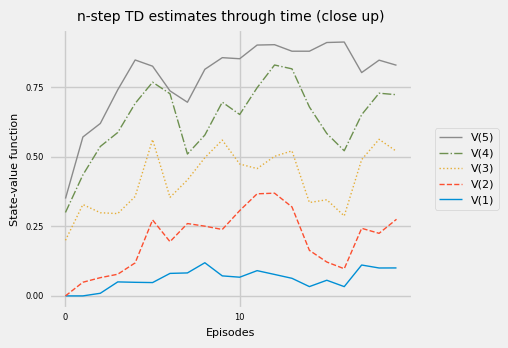

In [45]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:20], None, log=False)

# TD(λ)

In [46]:
def td_lambda(pi, 
              env, 
              config: PredictionConfig,
              lambda_=0.3):
    
    nS = env.observation_space.n
    V = np.zeros(nS, dtype=np.float64)
    E = np.zeros(nS, dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    alphas = decay_schedule(
        config.init_alpha, config.min_alpha, 
        config.alpha_decay_ratio, config.n_episodes)
    for e in tqdm(range(config.n_episodes), leave=False):
        E.fill(0)
        state, info  = env.reset()
        done = False
        while not done:
            action = pi(state)
            next_state, reward, done, _,_ = env.step(action)
            td_target = reward + gamma * V[next_state] * (not done)
            td_error = td_target - V[state]
            E[state] = E[state] + 1
            V = V + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            state = next_state
        V_track[e] = V
    return V, V_track

In [47]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.action_space.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_tdls.append(V_tdl)
    V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls
del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
print_state_value_function(V_tdl, P, n_cols=7)
print()
print_state_value_function(V_tdl - V_true, P, n_cols=7, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00    0.0 | 01   0.16 | 02   0.33 | 03  0.486 | 04  0.663 | 05  0.838 | 06    0.0 |

State-value function errors:
| 00 -0.083 | 01 -0.007 | 02 -0.004 | 03 -0.014 | 04 -0.004 | 05  0.005 | 06 -0.417 |
RMSE: 0.1607


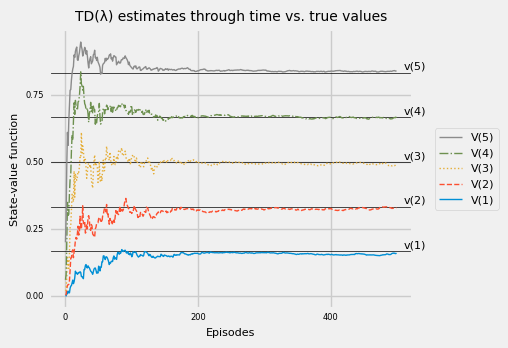

In [49]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

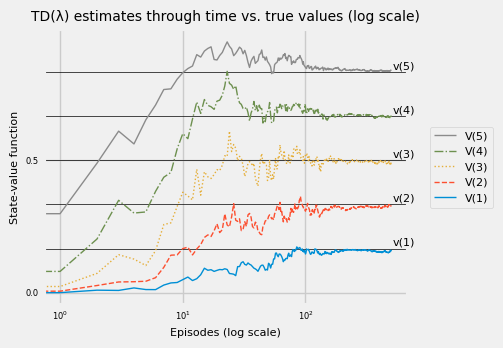

In [50]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

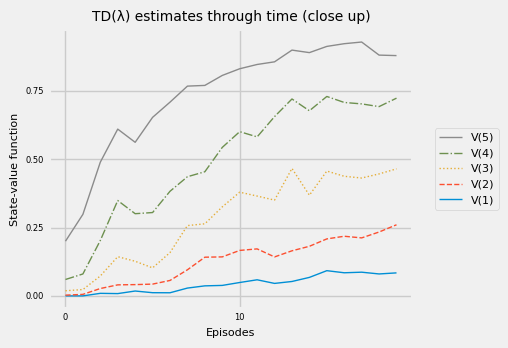

In [51]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:20], None, log=False)

# Russell & Norvig Gridworld environment and sample policy

In [52]:
env = gym.make('RussellNorvigGridworld-v0')
init_state,info = env.reset()
goal_state = 3
gamma = 1.0
n_episodes = 1000
P = env.unwrapped.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:RIGHT, 1:RIGHT, 2:RIGHT, 3:LEFT,
    4:UP,    5:LEFT,  6:UP,    7:LEFT,
    8:UP,    9:LEFT, 10:LEFT, 11:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.812 | 01  0.868 | 02  0.918 |           |
| 04  0.762 |           | 06   0.66 |           |
| 08  0.705 | 09  0.655 | 10  0.611 | 11  0.388 |

Policy:
| 00      > | 01      > | 02      > |           |
| 04      ^ |           | 06      ^ |           |
| 08      ^ | 09      < | 10      < | 11      < |
Reaches goal 97.00%. Obtains an average return of 0.7140.


# Russell & Norvig Gridworld policy estimation (policy to state-value function)

In [53]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [54]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
| 00  0.817 | 01  0.873 | 02  0.923 |           |
| 04  0.767 |           | 06  0.676 |           |
| 08  0.712 | 09  0.647 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00  0.005 | 01  0.006 | 02  0.005 |           |
| 04  0.005 |           | 06  0.015 |           |
| 08  0.007 | 09 -0.009 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2091


In [56]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes), first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
| 00  0.817 | 01  0.874 | 02  0.921 |           |
| 04  0.768 |           | 06  0.691 |           |
| 08   0.71 | 09  0.668 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00  0.005 | 01  0.006 | 02  0.003 |           |
| 04  0.007 |           | 06   0.03 |           |
| 08  0.005 | 09  0.013 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2093


In [60]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [61]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.801 | 01  0.859 | 02  0.909 |           |
| 04  0.752 |           | 06  0.606 |           |
| 08  0.694 | 09  0.633 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.011 | 01 -0.009 | 02 -0.009 |           |
| 04  -0.01 |           | 06 -0.055 |           |
| 08 -0.012 | 09 -0.022 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2098


In [62]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00  0.809 | 01  0.871 | 02  0.926 |           |
| 04  0.761 |           | 06  0.662 |           |
| 08  0.699 | 09  0.658 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.002 | 01  0.003 | 02  0.008 |           |
| 04 -0.001 |           | 06  0.002 |           |
| 08 -0.006 | 09  0.003 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2091


In [64]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00  0.811 | 01  0.866 | 02  0.914 |           |
| 04   0.76 |           | 06   0.62 |           |
| 08  0.703 | 09  0.646 | 10    0.0 | 11    0.0 |

State-value function errors:
| 00 -0.001 | 01 -0.002 | 02 -0.004 |           |
| 04 -0.001 |           | 06  -0.04 |           |
| 08 -0.002 | 09  -0.01 | 10 -0.611 | 11 -0.388 |
RMSE: 0.2094


# Russell & Norvig Gridworld state-value function estimation

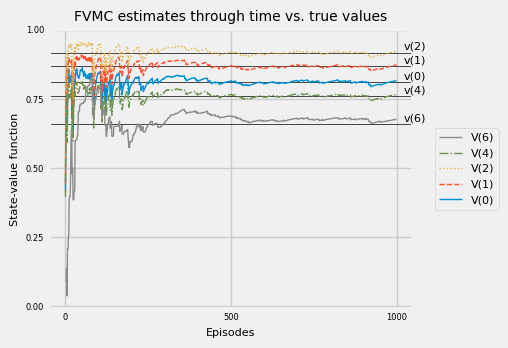

In [66]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

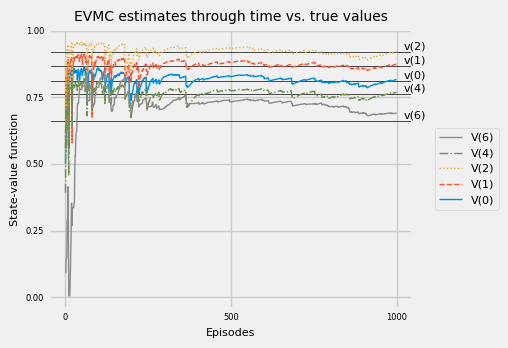

In [67]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

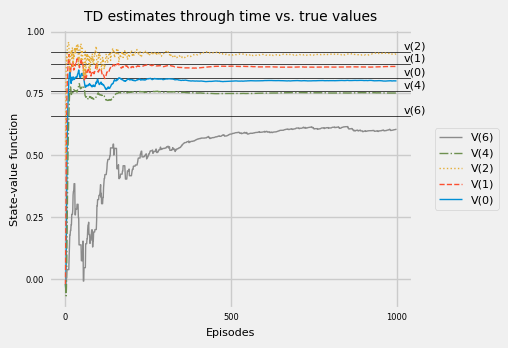

In [68]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

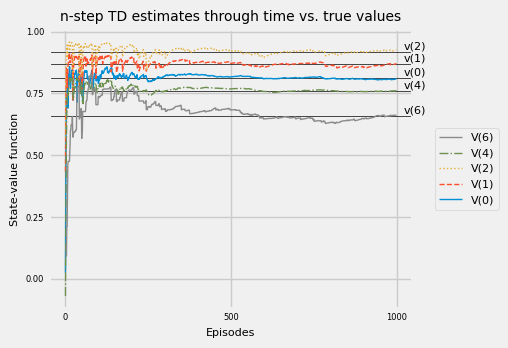

In [69]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

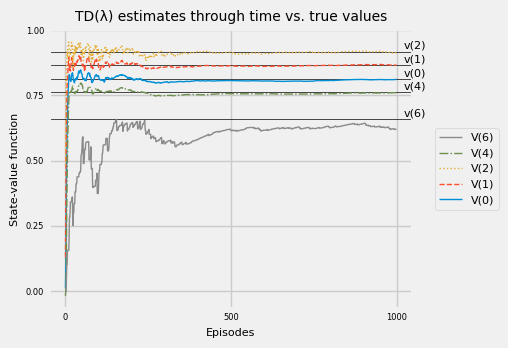

In [70]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

# Russell & Norvig Gridworld state-value function estimation (x axis in log scale)

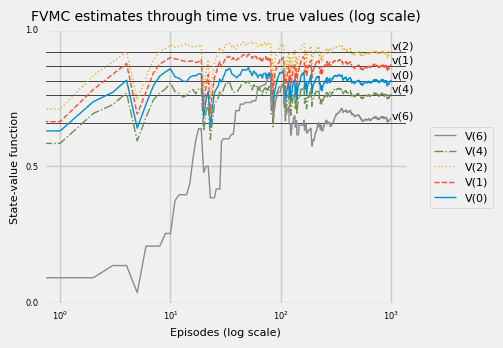

In [71]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

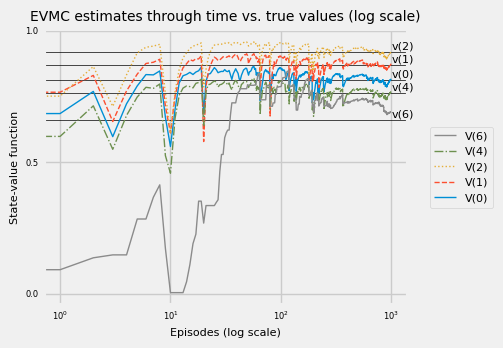

In [72]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

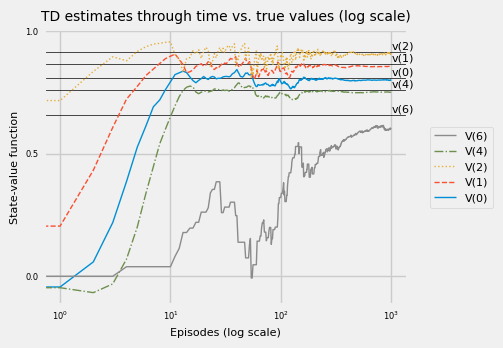

In [73]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

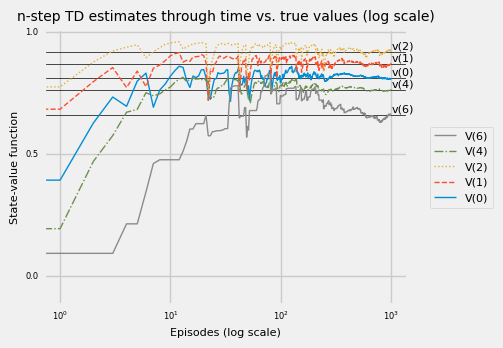

In [74]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

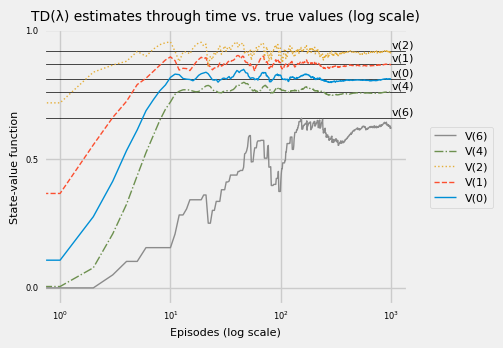

In [75]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

# Close ups

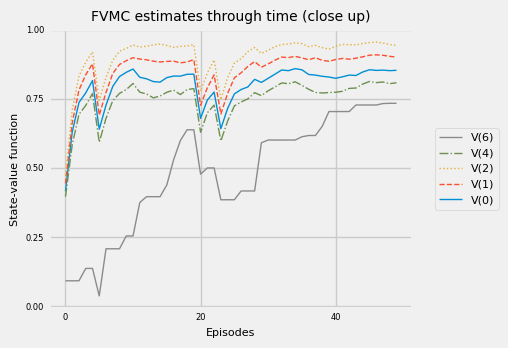

In [76]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:50], None, log=False)

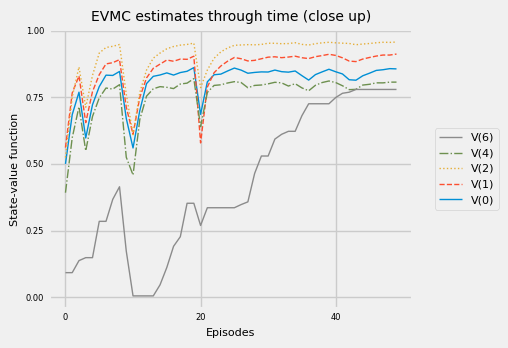

In [77]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:50], None, log=False)

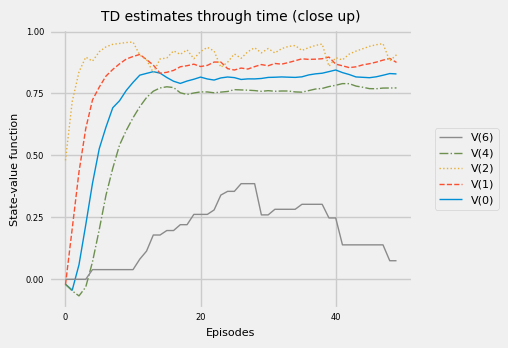

In [78]:
plot_value_function('TD estimates through time (close up)', V_track_td[:50], None, log=False)

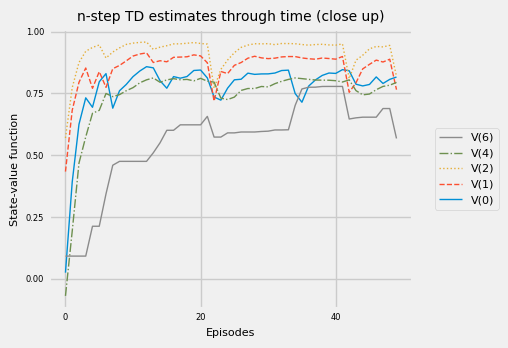

In [79]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:50], None, log=False)

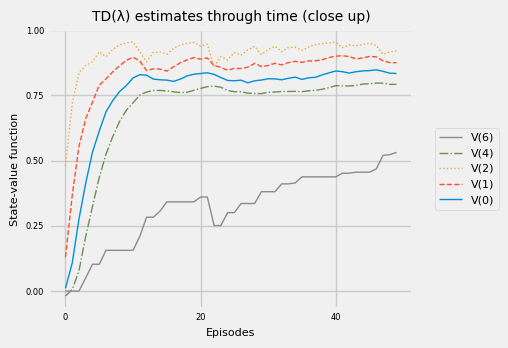

In [80]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:50], None, log=False)

# MC vs. TD

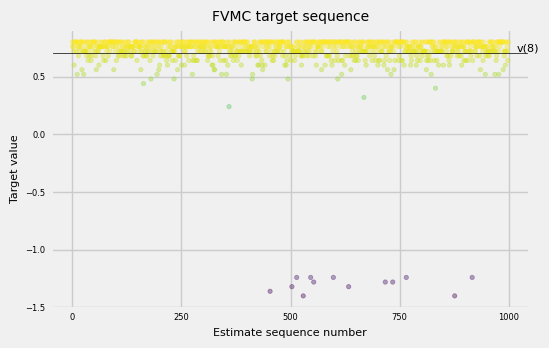

In [81]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

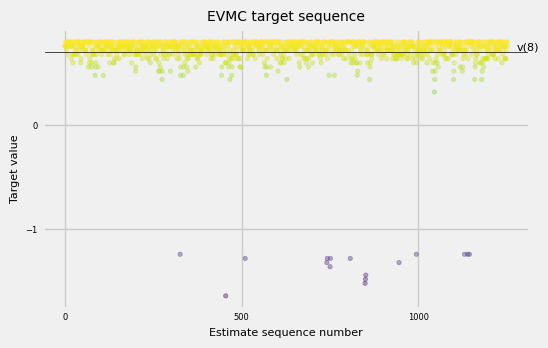

In [82]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

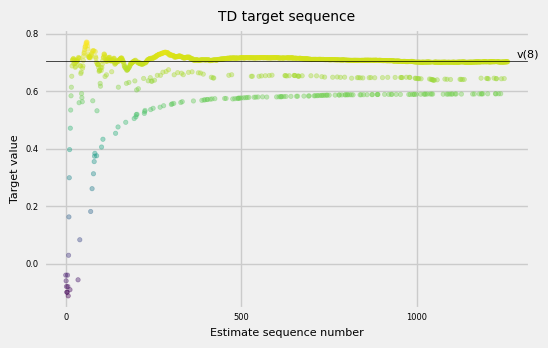

In [83]:
plot_targets(targets_td, init_state, title='TD target sequence')

# FrozenLake environment and sample policy

In [84]:
env = gym.make('FrozenLake-v1')
init_state,info = env.reset()
goal_state = 15
gamma = 0.99
n_episodes = 2500
P = env.unwrapped.P

LEFT, DOWN, RIGHT, UP = range(4)
pi = lambda s: {
    0:LEFT,   1:UP,     2:UP,    3:UP,
    4:LEFT,   5:LEFT,   6:LEFT,  7:LEFT,
    8:UP,     9:DOWN,  10:LEFT, 11:LEFT,
    12:LEFT, 13:RIGHT, 14:DOWN, 15:LEFT
}[s]
V_true = policy_evaluation(pi, P, gamma=gamma)

print_state_value_function(V_true, P)
print()

print_policy(pi, P)
print('Reaches goal {:.2f}%. Obtains an average return of {:.4f}.'.format(
    probability_success(env, pi, goal_state=goal_state), 
    mean_return(env, gamma, pi)))

State-value function:
| 00  0.542 | 01  0.499 | 02  0.471 | 03  0.457 |
| 04  0.558 |           | 06  0.358 |           |
| 08  0.592 | 09  0.643 | 10  0.615 |           |
|           | 13  0.742 | 14  0.863 |           |

Policy:
| 00      < | 01      ^ | 02      ^ | 03      ^ |
| 04      < |           | 06      < |           |
| 08      ^ | 09      v | 10      < |           |
|           | 13      > | 14      v |           |
Reaches goal 83.00%. Obtains an average return of 0.4927.


# FrozenLake policy estimation (policy to state-value function)

In [85]:
V_fvmcs, V_track_fvmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed)
    np.random.seed(seed)
    env.action_space.seed(seed)
    V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_fvmcs.append(V_fvmc) ; V_track_fvmcs.append(V_track_fvmc)
V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)
del V_fvmcs ; del V_track_fvmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [86]:
print_state_value_function(V_fvmc, P)
print()
print_state_value_function(V_fvmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_fvmc, V_true))

State-value function:
| 00  0.548 | 01  0.515 | 02  0.486 | 03  0.474 |
| 04  0.564 |           | 06  0.372 |           |
| 08  0.599 | 09  0.653 | 10  0.625 |           |
|           | 13  0.752 | 14  0.877 |           |

State-value function errors:
| 00  0.005 | 01  0.016 | 02  0.016 | 03  0.017 |
| 04  0.005 |           | 06  0.013 |           |
| 08  0.007 | 09   0.01 | 10   0.01 |           |
|           | 13  0.011 | 14  0.015 |           |
RMSE: 0.01


In [87]:
V_evmcs, V_track_evmcs = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_evmc, V_track_evmc, targets_evmc = mc_prediction(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes), first_visit=False)
    V_evmcs.append(V_evmc) ; V_track_evmcs.append(V_track_evmc)
V_evmc, V_track_evmc = np.mean(V_evmcs, axis=0), np.mean(V_track_evmcs, axis=0)
del V_evmcs ; del V_track_evmcs

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [88]:
print_state_value_function(V_evmc, P)
print()
print_state_value_function(V_evmc - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_evmc, V_true))

State-value function:
| 00  0.574 | 01  0.554 | 02  0.524 | 03  0.504 |
| 04  0.598 |           | 06  0.369 |           |
| 08    0.6 | 09  0.645 | 10  0.625 |           |
|           | 13  0.769 | 14  0.869 |           |

State-value function errors:
| 00  0.032 | 01  0.056 | 02  0.053 | 03  0.047 |
| 04   0.04 |           | 06  0.011 |           |
| 08  0.008 | 09  0.002 | 10   0.01 |           |
|           | 13  0.027 | 14  0.006 |           |
RMSE: 0.0271


In [89]:
V_tds, V_track_tds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_td, V_track_td, targets_td = td(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_tds.append(V_td) ; V_track_tds.append(V_track_td)
V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)
del V_tds ; del V_track_tds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [90]:
print_state_value_function(V_td, P)
print()
print_state_value_function(V_td - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_td, V_true))

State-value function:
| 00  0.544 | 01  0.503 | 02  0.476 | 03  0.463 |
| 04   0.56 |           | 06  0.355 |           |
| 08  0.594 | 09  0.642 | 10  0.608 |           |
|           | 13  0.748 | 14  0.867 |           |

State-value function errors:
| 00  0.002 | 01  0.004 | 02  0.005 | 03  0.006 |
| 04  0.002 |           | 06 -0.004 |           |
| 08  0.002 | 09 -0.001 | 10 -0.007 |           |
|           | 13  0.006 | 14  0.004 |           |
RMSE: 0.0037


In [91]:
V_ntds, V_track_ntds = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_ntd, V_track_ntd = ntd(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_ntds.append(V_ntd) ; V_track_ntds.append(V_track_ntd)
V_ntd, V_track_ntd = np.mean(V_ntds, axis=0), np.mean(V_track_ntds, axis=0)
del V_ntds ; del V_track_ntds

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [92]:
print_state_value_function(V_ntd, P)
print()
print_state_value_function(V_ntd - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_ntd, V_true))

State-value function:
| 00  0.539 | 01  0.499 | 02  0.472 | 03  0.458 |
| 04  0.558 |           | 06  0.361 |           |
| 08  0.596 | 09  0.648 | 10  0.619 |           |
|           | 13  0.745 | 14  0.869 |           |

State-value function errors:
| 00 -0.004 | 01    0.0 | 02  0.002 | 03  0.001 |
| 04 -0.001 |           | 06  0.003 |           |
| 08  0.004 | 09  0.005 | 10  0.003 |           |
|           | 13  0.004 | 14  0.006 |           |
RMSE: 0.0028


In [93]:
V_tdls, V_track_tdls = [], []
for seed in tqdm(SEEDS, desc='All seeds', leave=True):
    random.seed(seed); np.random.seed(seed) ; env.action_space.seed(seed)
    V_tdl, V_track_tdl = td_lambda(pi, env, PredictionConfig(gamma=gamma, n_episodes=n_episodes))
    V_tdls.append(V_tdl) ; V_track_tdls.append(V_track_tdl)
V_tdl, V_track_tdl = np.mean(V_tdls, axis=0), np.mean(V_track_tdls, axis=0)
del V_tdls ; del V_track_tdls

All seeds:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [94]:
print_state_value_function(V_tdl, P)
print()
print_state_value_function(V_tdl - V_true, P, title='State-value function errors:')
print('RMSE:', rmse(V_tdl, V_true))

State-value function:
| 00  0.546 | 01  0.503 | 02  0.478 | 03  0.464 |
| 04  0.561 |           | 06  0.372 |           |
| 08  0.593 | 09  0.643 | 10  0.618 |           |
|           | 13  0.743 | 14  0.868 |           |

State-value function errors:
| 00  0.004 | 01  0.005 | 02  0.007 | 03  0.007 |
| 04  0.003 |           | 06  0.014 |           |
| 08  0.001 | 09   -0.0 | 10  0.003 |           |
|           | 13  0.001 | 14  0.006 |           |
RMSE: 0.0049


# FrozenLake state-value function estimation

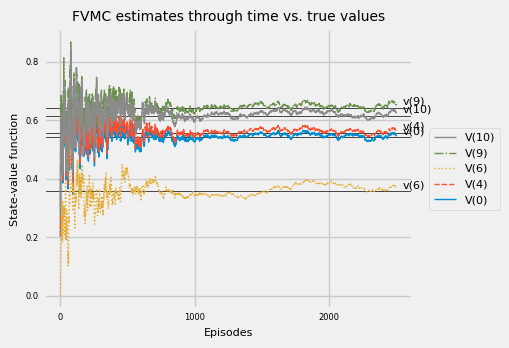

In [95]:
plot_value_function('FVMC estimates through time vs. true values', V_track_fvmc, V_true, log=False)

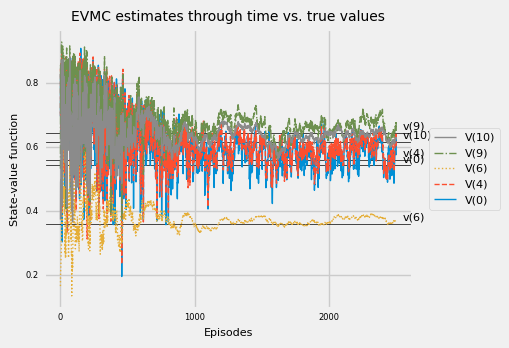

In [96]:
plot_value_function('EVMC estimates through time vs. true values', V_track_evmc, V_true, log=False)

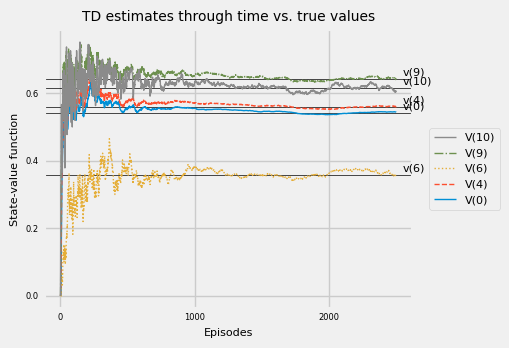

In [97]:
plot_value_function('TD estimates through time vs. true values', V_track_td, V_true, log=False)

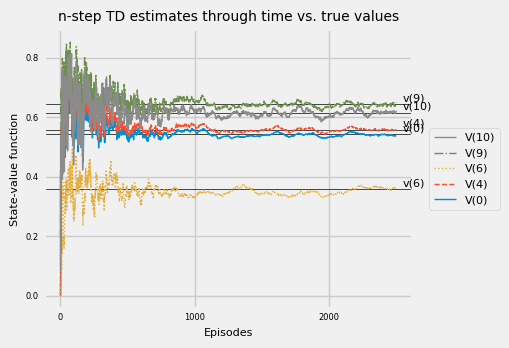

In [98]:
plot_value_function('n-step TD estimates through time vs. true values', V_track_ntd, V_true, log=False)

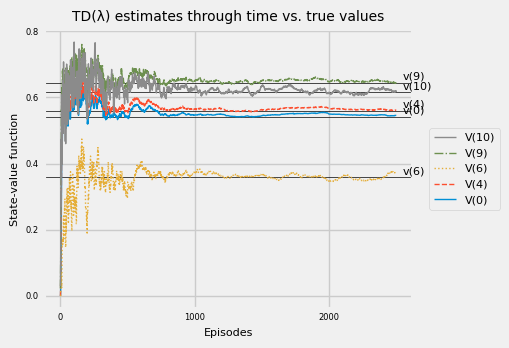

In [99]:
plot_value_function('TD(λ) estimates through time vs. true values', V_track_tdl, V_true, log=False)

# FrozenLake state-value function estimation (x axis in log scale)

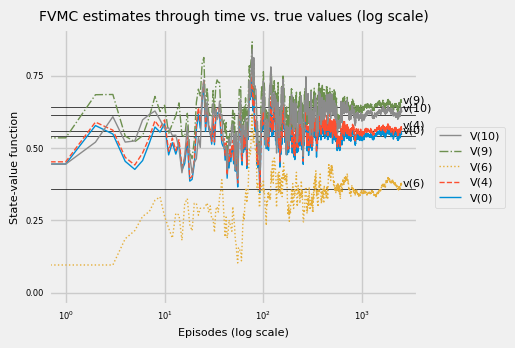

In [100]:
plot_value_function('FVMC estimates through time vs. true values (log scale)', V_track_fvmc, V_true, log=True)

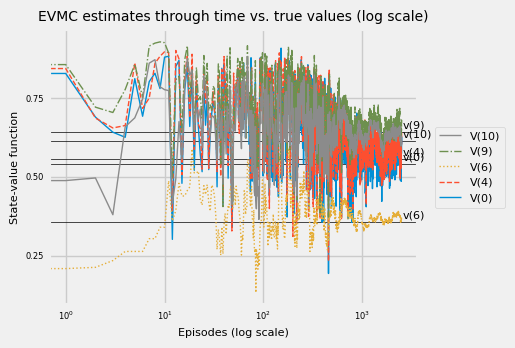

In [101]:
plot_value_function('EVMC estimates through time vs. true values (log scale)', V_track_evmc, V_true, log=True)

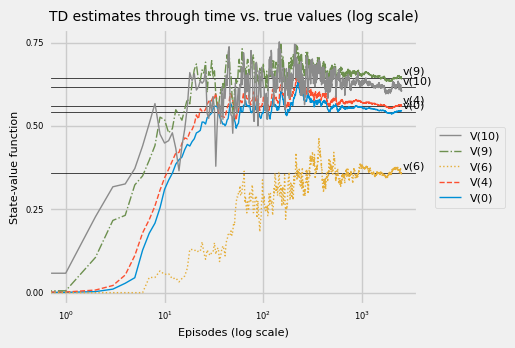

In [102]:
plot_value_function('TD estimates through time vs. true values (log scale)', V_track_td, V_true, log=True)

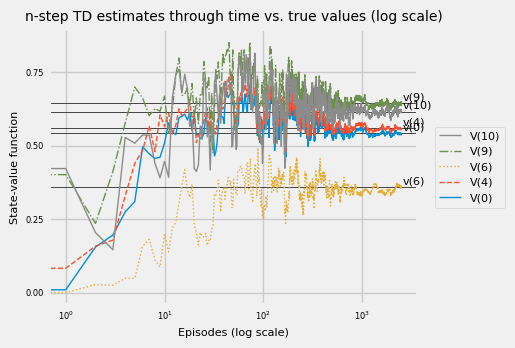

In [103]:
plot_value_function('n-step TD estimates through time vs. true values (log scale)', V_track_ntd, V_true, log=True)

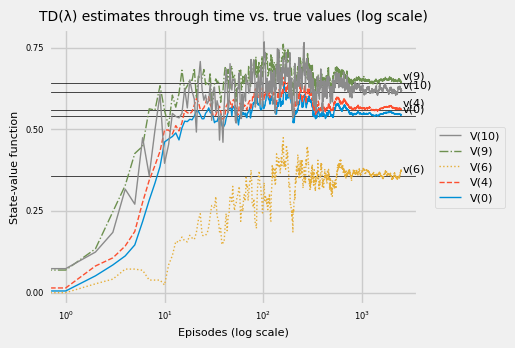

In [104]:
plot_value_function('TD(λ) estimates through time vs. true values (log scale)', V_track_tdl, V_true, log=True)

# Close ups

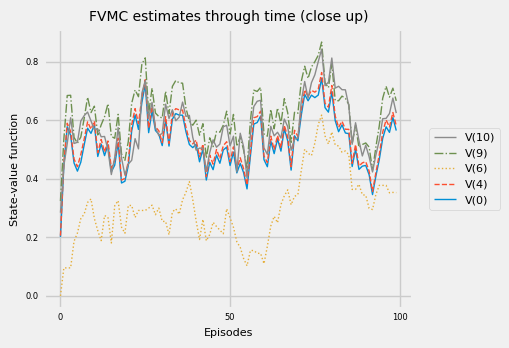

In [105]:
plot_value_function('FVMC estimates through time (close up)', V_track_fvmc[:100], None, log=False)

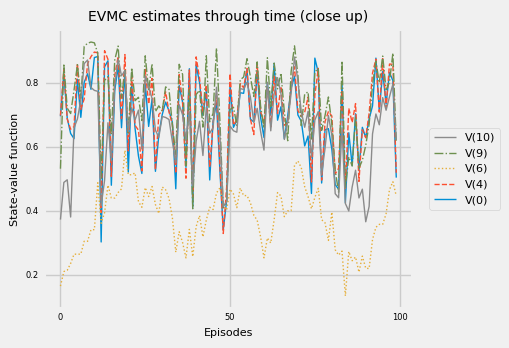

In [106]:
plot_value_function('EVMC estimates through time (close up)', V_track_evmc[:100], None, log=False)

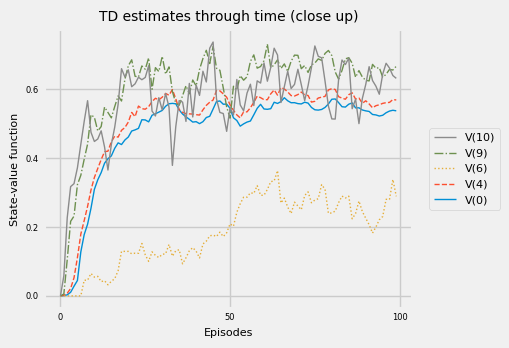

In [107]:
plot_value_function('TD estimates through time (close up)', V_track_td[:100], None, log=False)

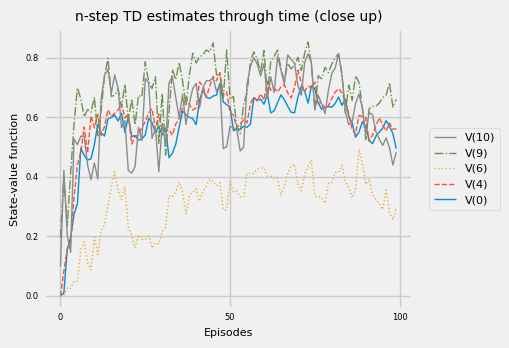

In [108]:
plot_value_function('n-step TD estimates through time (close up)', V_track_ntd[:100], None, log=False)

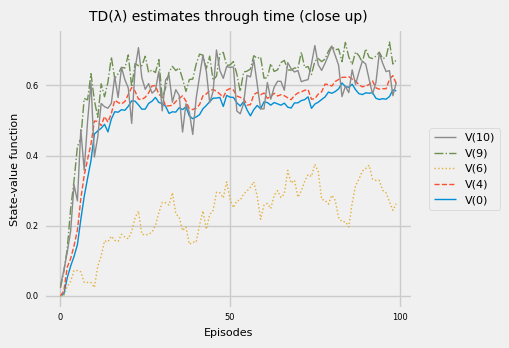

In [109]:
plot_value_function('TD(λ) estimates through time (close up)', V_track_tdl[:100], None, log=False)

# MC vs. TD

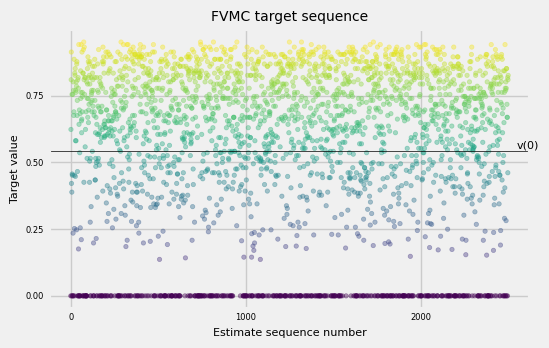

In [110]:
plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

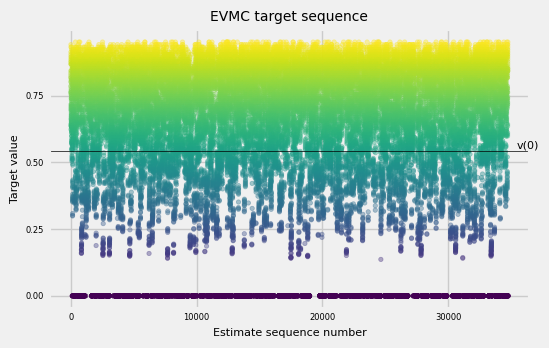

In [111]:
plot_targets(targets_evmc, init_state, title='EVMC target sequence')

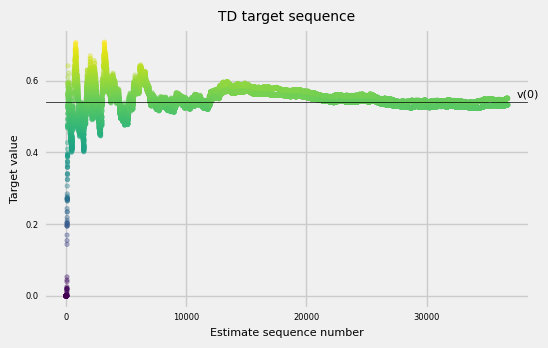

In [112]:
plot_targets(targets_td, init_state, title='TD target sequence')